In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm

from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

## Device

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cpu')

In [3]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Using cache found in C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
ls

 Volume in drive E is DATA
 Volume Serial Number is B867-DA30

 Directory of E:\[1]-Cascade learning-Unsafe behavior of cranes\ml_mo\safety_status_classification_module\classification

22/09/2024  12:36 pm    <DIR>          .
20/09/2024  11:30 am    <DIR>          ..
20/09/2024  12:04 pm    <DIR>          .ipynb_checkpoints
20/09/2024  11:41 am    <DIR>          classification_data
20/09/2024  12:15 pm    <DIR>          classification_dataset
10/08/2024  05:10 pm            53,006 confusion_matrix.png
10/08/2024  05:11 pm            79,416 dino_classification_results.ipynb
22/09/2024  12:13 pm            73,165 dino_classification_training.ipynb
19/07/2024  04:12 am        88,688,561 dino_model.pth
20/07/2024  12:33 pm        88,725,096 dino_model_.pth
20/07/2024  12:33 pm        88,725,279 dino_model_1.pth
22/09/2024  12:36 pm        88,729,266 dino_model_epoch2.pth
22/09/2024  12:36 pm        88,729,449 dino_model_epoch22.pth
02/08/2024  11:15 am            77,176 tower_crane_vit.ipy

In [32]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

# Set a seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def collect_images(base_path, label):
    images = []
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        i=0
        for img_file in os.listdir(folder_path):
            if img_file.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
                images.append((os.path.join(folder_path, img_file), label))
                
    return images

# Collect images from both directories
safe_images = collect_images('classification_data/mobile_crane/safe', label=0)
unsafe_images = collect_images('classification_data/mobile_crane/unsafe', label=1)
safe_images += collect_images('classification_data/tower_crane/safe', label=0)
unsafe_images += collect_images('classification_data/tower_crane/unsafe', label=1)

# Combine images and split into train/test
all_images = safe_images + unsafe_images
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=seed_value)

# Print out the number of images in each set
print(f"Training images: {len(train_images)}")
print(f"Testing images: {len(test_images)}")


Training images: 16107
Testing images: 4027


## Prepare Dataset

In [33]:
class CustomImageDataset(datasets.VisionDataset):
    def __init__(self, image_label_pairs, transform=None):
        super().__init__(root="", transform=transform)
        self.image_paths = [img[0] for img in image_label_pairs]
        self.labels = [img[1] for img in image_label_pairs]
        self.transform = transform
        self.classes = ['Safe', 'Unsafe']

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = datasets.folder.default_loader(img_path)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Create datasets
image_datasets = {
    'train': CustomImageDataset(train_images, transform=data_transforms['train']),
    'test': CustomImageDataset(test_images, transform=data_transforms['test'])
}

# Output the dataset sizes
print(f"Training set size: {len(image_datasets['train'])}")
print(f"Test set size: {len(image_datasets['test'])}")

Training set size: 16107
Test set size: 4027


In [34]:
image_datasets

{'train': Dataset CustomImageDataset
     Number of datapoints: 16107
     Root location: 
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset CustomImageDataset
     Number of datapoints: 4027
     Root location: 
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [35]:
batch_size = 16
num_workers = 4
data_loaders = {x: DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=0)
                for x in ['train', 'test']}


In [36]:
for img, label in data_loaders['train']:
    print(img.shape)
    print(label)
    break

torch.Size([16, 3, 224, 224])
tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])


In [37]:
class_names = image_datasets['train'].classes
class_names

['Safe', 'Unsafe']

## Model

In [38]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x

model = DinoVisionTransformerClassifier()
model = model.to(device)

In [39]:
model

DinoVisionTransformerClassifier(
  (transformer): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, in

In [40]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [41]:
input_data = torch.randn(16, 3, 224, 224)
out=model(input_data)
print(out.shape)

torch.Size([16, 1])


In [42]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 22155393


In [43]:
from sklearn.metrics import f1_score
num_epoch = 20

def calculate_score(labels, predictions):

    # Calculate TP, TN, FP, FN
    TP = ((predictions == 1) & (labels == 1)).sum().item()
    TN = ((predictions == 0) & (labels == 0)).sum().item()
    FP = ((predictions == 1) & (labels == 0)).sum().item()
    FN = ((predictions == 0) & (labels == 1)).sum().item()

    # Calculate precision and recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    return f1,accuracy

In [44]:
model_load_path = "dino_model_1.pth"
model = torch.load(model_load_path)

In [45]:
model

DinoVisionTransformerClassifier(
  (transformer): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, in

In [46]:
correct = 0
total = 0
test_predicted = []
test_labels = []


model.eval()

with torch.no_grad():
    for features, labels in data_loaders["test"]:
        features = features.to(device)
        labels = labels.to(device).float() 
        outputs = model(features)

        # Convert outputs to binary predictions
        predicted = (outputs > 0.5).float()
        total += labels.size(0)

        test_labels += labels.cpu().numpy().tolist()
        test_predicted += predicted.cpu().numpy().tolist()


In [47]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Given data
labels = np.array(test_labels)
predictions = np.array(test_predicted)

# Flatten predictions if they are in a 2D array
predictions = predictions.flatten()

# Calculate F1 Score
f1 = f1_score(labels, predictions)
print(f"F1 Score: {f1}")

# Calculate Accuracy
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy}")




F1 Score: 0.9626648781578357
Accuracy: 0.9585299230196176


In [54]:
report = classification_report(test_labels, test_predicted, target_names=class_names, output_dict=True)

# Extract overall precision and recall
overall_precision = report['weighted avg']['precision']
overall_recall = report['weighted avg']['recall']

print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")

Overall Precision: 0.96
Overall Recall: 0.96


## Report

In [48]:
print(classification_report(test_labels, test_predicted, target_names=class_names))

              precision    recall  f1-score   support

        Safe       0.97      0.93      0.95      1829
      Unsafe       0.95      0.98      0.96      2198

    accuracy                           0.96      4027
   macro avg       0.96      0.96      0.96      4027
weighted avg       0.96      0.96      0.96      4027



In [49]:
cm = confusion_matrix(test_labels, test_predicted)
df_cm = pd.DataFrame(
    cm,
    index = class_names,
    columns = class_names
)
df_cm

,Safe,Unsafe
Safe,1707,122
Unsafe,45,2153


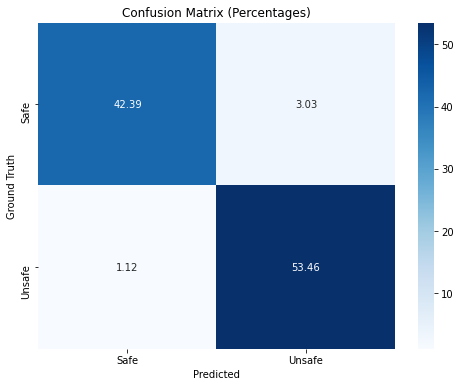

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def show_confusion_matrix(confusion_matrix):
    total = np.sum(confusion_matrix)
    percentages = (confusion_matrix / total) * 100
    

    plt.figure(figsize=(8, 6))
    hmap = sns.heatmap(percentages, annot=True, fmt=".2f", cmap="Blues", 
                      xticklabels=['Safe', 'Unsafe'], 
                      yticklabels=['Safe', 'Unsafe'])
    
    plt.ylabel("Ground Truth")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix (Percentages)")
    plt.show()


confusion_matrix = np.array(df_cm)

show_confusion_matrix(confusion_matrix)


Confusion matrix saved as confusion_matrix.png


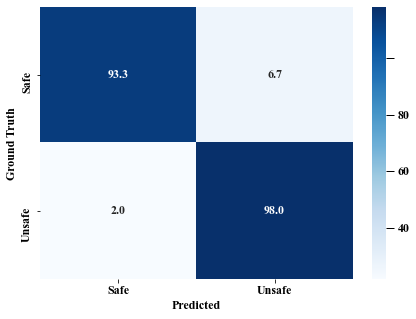

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

save_path = "confusion_matrix.png"

def show_confusion_matrix(confusion_matrix):
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    percentages = (confusion_matrix / row_sums) * 100

    annotations = np.empty_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            count = confusion_matrix[i, j]
            percent = percentages[i, j]
            annotations[i, j] = f"{percent:.1f}"

    plt.figure(figsize=(7, 5))
    heatmap = sns.heatmap(percentages, annot=annotations, fmt="", cmap="Blues",
                         xticklabels=['Safe', 'Unsafe'],
                         yticklabels=['Safe', 'Unsafe'],
                         annot_kws={"size": 12, 'fontname': 'Times New Roman', "weight": 'bold'})
    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=12, labelcolor='black', width=2, length=8)
    colorbar.ax.yaxis.set_tick_params(size=8, width=1)

    # Update the legend ticks to show 0% to 100% in increments of 20%
    legend_ticks= [0, 20, 40, 60, 80, 100]
    colorbar.set_ticks(legend_ticks)
    colorbar.set_ticklabels([f"{tick}%" for tick in legend_ticks])

    # Use FixedLocator to fix the warning
    colorbar.ax.yaxis.set_major_locator(plt.FixedLocator(legend_ticks))
    colorbar.ax.set_yticklabels(colorbar.ax.get_yticklabels(),
                               fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontname': 'Times New Roman'})

    plt.xticks(fontsize=12, fontname='Times New Roman', fontweight='bold')
    plt.yticks(fontsize=12, fontname='Times New Roman', fontweight='bold')
    plt.ylabel("Ground Truth", fontsize=12, fontname='Times New Roman', fontweight='bold')
    plt.xlabel("Predicted", fontsize=12, fontname='Times New Roman', fontweight='bold')
    # plt.title("Confusion Matrix", fontsize=14, fontweight='bold', fontname='Times New Roman')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved as {save_path}")

confusion_matrix = np.array(df_cm)
show_confusion_matrix(confusion_matrix)


No handles with labels found to put in legend.


Confusion matrix saved as confusion_matrix.png


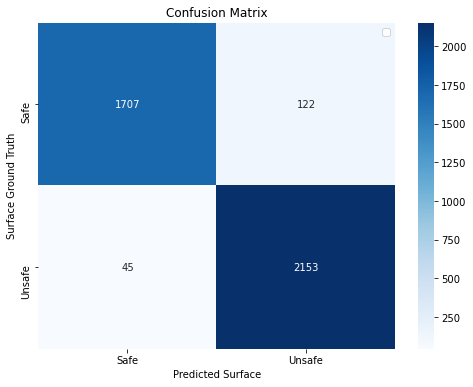

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  

def show_confusion_matrix(confusion_matrix, save_path=None):
    plt.figure(figsize=(8, 6))
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.title("Confusion Matrix")
    plt.legend() 

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved as {save_path}")

    plt.show()
show_confusion_matrix(df_cm, save_path="confusion_matrix.png")

In [53]:

cr = classification_report(test_labels, test_predicted, target_names=['Safe', 'Unsafe'])

# Print classification report
print("Classification Report:\n", cr)


Classification Report:
               precision    recall  f1-score   support

        Safe       0.97      0.93      0.95      1829
      Unsafe       0.95      0.98      0.96      2198

    accuracy                           0.96      4027
   macro avg       0.96      0.96      0.96      4027
weighted avg       0.96      0.96      0.96      4027

